# study the different signal categories ie resolved-b / boosted-bb & boostedTaus/HPS

In [1]:
import uproot
import awkward as ak
import numpy as np
import hist
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)
from collections import defaultdict
import matplotlib.ticker as mtick

In [2]:
ars = {mass : uproot.concatenate([f"/grid_mnt/data__data.polcms/cms/cuisset/cmt/PreprocessRDF/bul_2018_ZZ_v12/GluGluToXToZZTo2B2Tau_M{mass}/cat_base/prod_241023g/data_{i}.root:Events" for i in range(1)], how="zip", 
    filter_name=["FatJet_particleNet*", "FatJet_pt", "FatJet_eta", "FatJet_phi", "fatjet_JetIdx", "*PairType", "gen*", "is*", "pairType*", "bjet1_JetIdx", "bjet2_JetIdx", "Jet_btagDeepFlavB", "Jet_pt", "Jet_eta",
                 "dau*", "HLT_*", "MET_pt", "Tau_eta", "Tau_phi", "Tau_decayMode", "Tau_pt", "Tau_dz", "Tau_idDeepTau2017*"]
) for mass in [200, 1000, 2000, 3000, 4000, 5000]}

In [52]:
ar = ars[1000]
ar

<Array [{MET_pt: 80, ...}, {...}, ..., {...}] type='131772 * {MET_pt: float...'>

In [63]:
weird = ak.any((ar.FatJet_particleNetLegacy_Xbb + ar.FatJet_particleNetLegacy_QCD) == 0, axis=-1)
ar[weird][3].FatJet[["pt", "particleNetLegacy_QCD"]]#[2]

AttributeError: no field named 'FatJet_particleNetLegacy_Xbb'

In [3]:
def pnet_bb_branch(ar):
    return ar.FatJet.particleNetLegacy_Xbb/(ar.FatJet.particleNetLegacy_Xbb + ar.FatJet.particleNetLegacy_QCD)
def hasBoosted_bb(ar):
    s = ak.singletons(ar.fatjet_JetIdx)
    s = s[s>=0]
    return ak.fill_none(ak.firsts(pnet_bb_branch(ar)[s]) >= 0.9172, False)
def isRes2b(ar):
    b1 = ak.singletons(ar.bjet1_JetIdx)
    b1 = b1[b1>=0]
    b2 = ak.singletons(ar.bjet2_JetIdx)
    b2 = b2[b2>=0]
    return ak.fill_none(ak.firsts(ar.Jet.btagDeepFlavB[b1]) >= 0.2770, False) & ak.fill_none(ak.firsts(ar.Jet.btagDeepFlavB[b2]) >= 0.2770, False)
def isRes1b(ar):
    b1 = ak.singletons(ar.bjet1_JetIdx)
    b1 = b1[b1>=0]
    b2 = ak.singletons(ar.bjet2_JetIdx)
    b2 = b2[b2>=0]
    return (ak.fill_none(ak.firsts(ar.Jet.btagDeepFlavB[b1]) >= 0.2770, False) | ak.fill_none(ak.firsts(ar.Jet.btagDeepFlavB[b2]) >= 0.2770, False)) & (~isRes2b(ar))
def isRes1Or2b(ar):
    b1 = ak.singletons(ar.bjet1_JetIdx)
    b1 = b1[b1>=0]
    b2 = ak.singletons(ar.bjet2_JetIdx)
    b2 = b2[b2>=0]
    return (ak.fill_none(ak.firsts(ar.Jet.btagDeepFlavB[b1]) >= 0.2770, False) | ak.fill_none(ak.firsts(ar.Jet.btagDeepFlavB[b2]) >= 0.2770, False))
def isHPS(ar):
    return ar.pairType_HPSTaus >= 0
def isBoostedTau(ar):
    return ar.pairType_boostedTaus >= 0
def isReco(ar):
    return (isHPS(ar) | isBoostedTau(ar)) & (isRes1Or2b(ar) | hasBoosted_bb(ar))
def eff(branch_num, filter_denom):
    try:
        return ak.count_nonzero(branch_num) / ak.count_nonzero(filter_denom)
    except:
        return ak.count_nonzero(branch_num) / len(filter_denom)

(exptext: Custom Text(0.001, 1, 'CMS'),
 expsuffix: Custom Text(0.001, 1.005, 'Simulation Preliminary'),
 supptext: Custom Text(1.012, 1, ''))

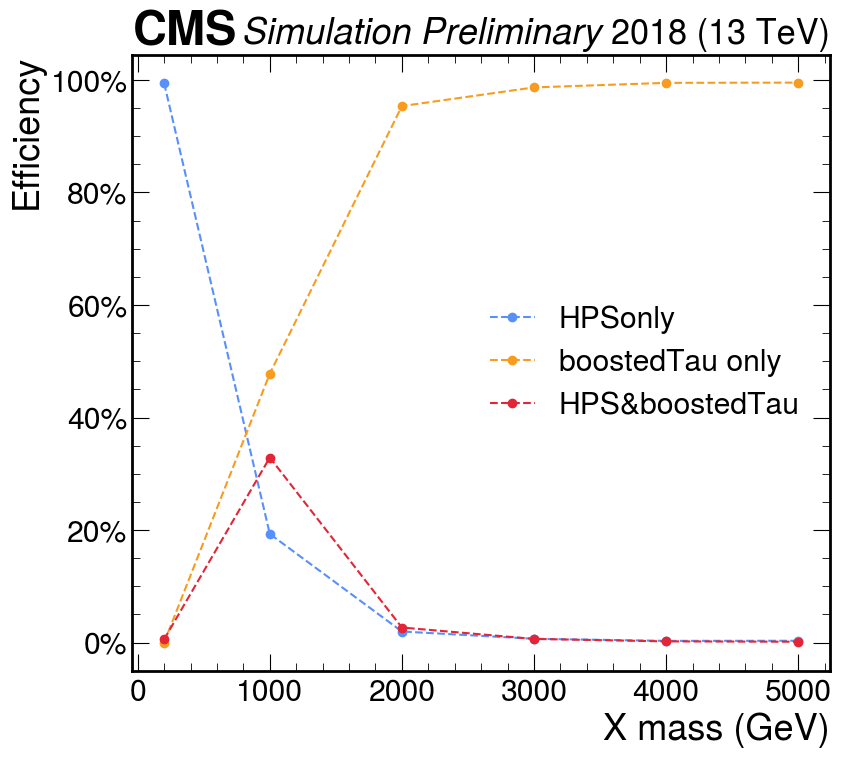

In [11]:
effs = defaultdict(dict)
for mass, ar in ars.items():
    effs["HPSonly"][mass] = eff(isReco(ar) & isHPS(ar) & ~isBoostedTau(ar), isReco(ar))
    effs["boostedTau only"][mass] = eff(isReco(ar) & ~isHPS(ar) & isBoostedTau(ar), isReco(ar))
    effs["HPS&boostedTau"][mass] = eff(isReco(ar) & isHPS(ar) & isBoostedTau(ar), isReco(ar))
    #effs["boostedTauOnly & resolved-b only"][mass] = eff(~isHPS(ar) & isBoostedTau(ar) & isRes1Or2b(ar) & ~hasBoosted_bb(ar), isReco(ar))

    # effs["!boostedTau & boosted-bb"][mass] = eff(~isBoostedTau(ar) & hasBoosted_bb(ar), ar)
    # effs["HPSTau & ~boostedTau & boosted-bb & !res"][mass] = eff(isHPS(ar) & hasBoosted_bb(ar), ar)

plt.figure(figsize=(9, 8))
for key, val in effs.items():
    plt.plot(val.keys(), val.values(), "o--", label=key)
# plt.plot(ars.keys(), eff_singlemu_trigger_genmatched.values(), label="HLT_IsoMu24 gen-matched")
plt.xlabel("X mass (GeV)")
plt.ylabel("Efficiency")
#plt.ylim(0, 1.3)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.rcParams['legend.title_fontsize'] = 'small'
plt.legend()
# plt.legend(title=r"$X\to Z_{bb}Z_{\tau\tau}$, $\tau_{\mu}\tau_{h}$ channel (gen-level filter)" "\n" 
#               r"Gen cuts: $\tau_{h}\tau_{h}$ decay" "\n"
#               r"$p_T(\tau_h) > 20 GeV, \eta(\tau_h) < 2.1$, $\Delta R(\tau\tau)<0.6$", loc="upper left", ncols=2)

hep.cms.label("Preliminary", year=2018)
#plt.savefig("studies/cutflow/cutflow_offline_muon_eff.pdf")

(exptext: Custom Text(0.001, 1, 'CMS'),
 expsuffix: Custom Text(0.001, 1.005, 'Simulation Preliminary'),
 supptext: Custom Text(1.012, 1, ''))

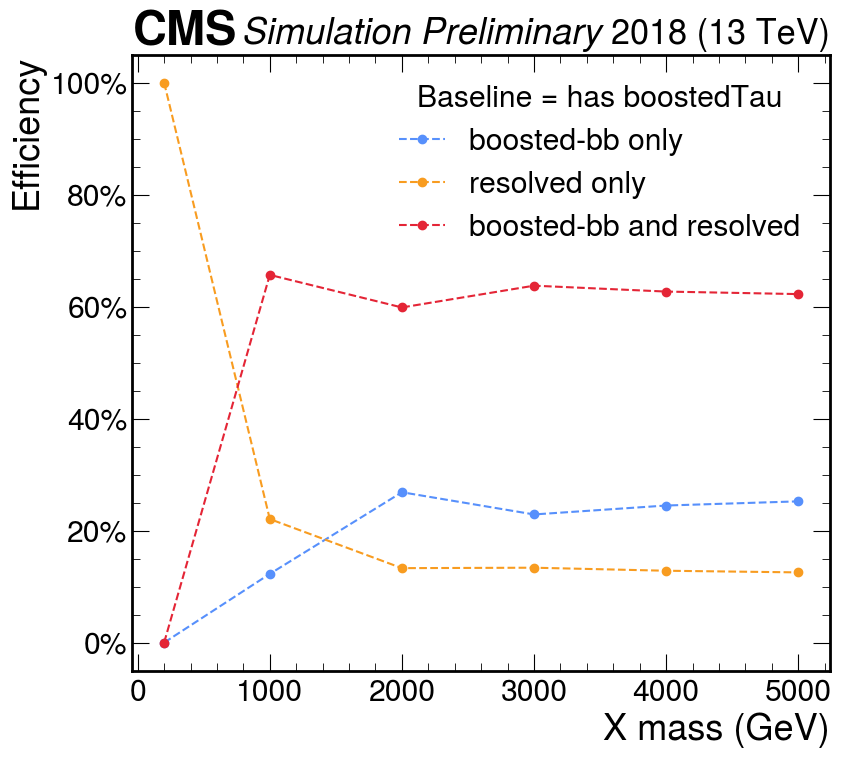

In [16]:
effs = defaultdict(dict)
for mass, ar in ars.items():
    effs["boosted-bb only"][mass] = eff(isReco(ar) & isBoostedTau(ar) & hasBoosted_bb(ar) & ~isRes1Or2b(ar), isReco(ar)& isBoostedTau(ar))
    effs["resolved only"][mass] = eff(isReco(ar) & isBoostedTau(ar) & ~hasBoosted_bb(ar) & isRes1Or2b(ar), isReco(ar)& isBoostedTau(ar))
    effs["boosted-bb and resolved"][mass] = eff(isReco(ar) & isBoostedTau(ar) & hasBoosted_bb(ar) & isRes1Or2b(ar), isReco(ar)& isBoostedTau(ar))
    #effs["boostedTauOnly & resolved-b only"][mass] = eff(~isHPS(ar) & isBoostedTau(ar) & isRes1Or2b(ar) & ~hasBoosted_bb(ar), isReco(ar))

    # effs["!boostedTau & boosted-bb"][mass] = eff(~isBoostedTau(ar) & hasBoosted_bb(ar), ar)
    # effs["HPSTau & ~boostedTau & boosted-bb & !res"][mass] = eff(isHPS(ar) & hasBoosted_bb(ar), ar)

plt.figure(figsize=(9, 8))
for key, val in effs.items():
    plt.plot(val.keys(), val.values(), "o--", label=key)
# plt.plot(ars.keys(), eff_singlemu_trigger_genmatched.values(), label="HLT_IsoMu24 gen-matched")
plt.xlabel("X mass (GeV)")
plt.ylabel("Efficiency")
#plt.ylim(0, 1.3)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.rcParams['legend.title_fontsize'] = 'small'
plt.legend(title="Baseline = has boostedTau")
# plt.legend(title=r"$X\to Z_{bb}Z_{\tau\tau}$, $\tau_{\mu}\tau_{h}$ channel (gen-level filter)" "\n" 
#               r"Gen cuts: $\tau_{h}\tau_{h}$ decay" "\n"
#               r"$p_T(\tau_h) > 20 GeV, \eta(\tau_h) < 2.1$, $\Delta R(\tau\tau)<0.6$", loc="upper left", ncols=2)

hep.cms.label("Preliminary", year=2018)
#plt.savefig("studies/cutflow/cutflow_offline_muon_eff.pdf")

(exptext: Custom Text(0.001, 1, 'CMS'),
 expsuffix: Custom Text(0.001, 1.005, 'Simulation Preliminary'),
 supptext: Custom Text(1.012, 1, ''))

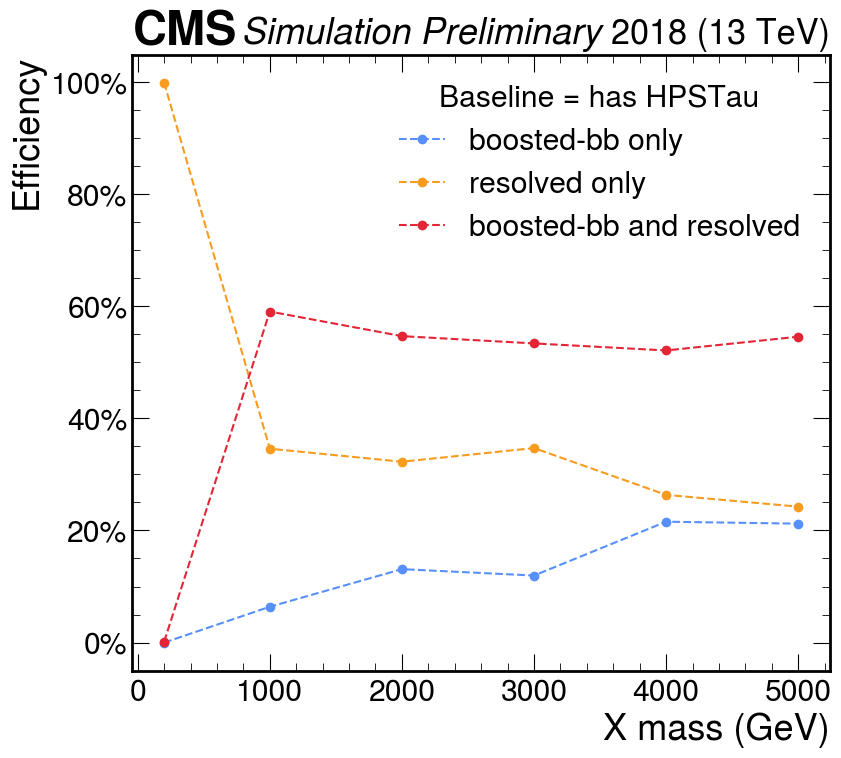

In [17]:
effs = defaultdict(dict)
for mass, ar in ars.items():
    effs["boosted-bb only"][mass] = eff(isReco(ar) & isHPS(ar) & hasBoosted_bb(ar) & ~isRes1Or2b(ar), isReco(ar) & isHPS(ar))
    effs["resolved only"][mass] = eff(isReco(ar) & isHPS(ar) & ~hasBoosted_bb(ar) & isRes1Or2b(ar), isReco(ar) & isHPS(ar))
    effs["boosted-bb and resolved"][mass] = eff(isReco(ar) & isHPS(ar) & hasBoosted_bb(ar) & isRes1Or2b(ar), isReco(ar) & isHPS(ar))
    #effs["boostedTauOnly & resolved-b only"][mass] = eff(~isHPS(ar) & isBoostedTau(ar) & isRes1Or2b(ar) & ~hasBoosted_bb(ar), isReco(ar))

    # effs["!boostedTau & boosted-bb"][mass] = eff(~isBoostedTau(ar) & hasBoosted_bb(ar), ar)
    # effs["HPSTau & ~boostedTau & boosted-bb & !res"][mass] = eff(isHPS(ar) & hasBoosted_bb(ar), ar)

plt.figure(figsize=(9, 8))
for key, val in effs.items():
    plt.plot(val.keys(), val.values(), "o--", label=key)
# plt.plot(ars.keys(), eff_singlemu_trigger_genmatched.values(), label="HLT_IsoMu24 gen-matched")
plt.xlabel("X mass (GeV)")
plt.ylabel("Efficiency")
#plt.ylim(0, 1.3)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.rcParams['legend.title_fontsize'] = 'small'
plt.legend(title="Baseline = has HPSTau")
# plt.legend(title=r"$X\to Z_{bb}Z_{\tau\tau}$, $\tau_{\mu}\tau_{h}$ channel (gen-level filter)" "\n" 
#               r"Gen cuts: $\tau_{h}\tau_{h}$ decay" "\n"
#               r"$p_T(\tau_h) > 20 GeV, \eta(\tau_h) < 2.1$, $\Delta R(\tau\tau)<0.6$", loc="upper left", ncols=2)

hep.cms.label("Preliminary", year=2018)
#plt.savefig("studies/cutflow/cutflow_offline_muon_eff.pdf")

(exptext: Custom Text(0.001, 1, 'CMS'),
 expsuffix: Custom Text(0.001, 1.005, 'Simulation Preliminary'),
 supptext: Custom Text(1.012, 1, ''))

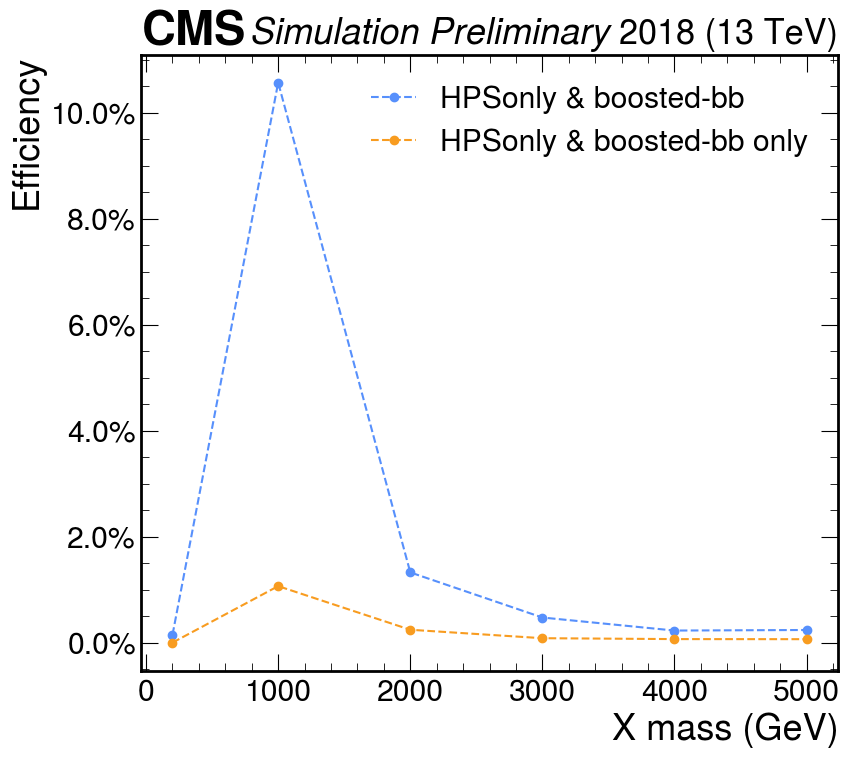

In [8]:
effs = defaultdict(dict)
for mass, ar in ars.items():
    effs["HPSonly & boosted-bb"][mass] = eff(isHPS(ar) & ~isBoostedTau(ar) & hasBoosted_bb(ar), isReco(ar))
    effs["HPSonly & boosted-bb only"][mass] = eff(isHPS(ar) & ~isBoostedTau(ar) & ~isRes1Or2b(ar) & hasBoosted_bb(ar), isReco(ar))
    #effs["boostedTauOnly & resolved-b only"][mass] = eff(~isHPS(ar) & isBoostedTau(ar) & isRes1Or2b(ar) & ~hasBoosted_bb(ar), isReco(ar))

    # effs["!boostedTau & boosted-bb"][mass] = eff(~isBoostedTau(ar) & hasBoosted_bb(ar), ar)
    # effs["HPSTau & ~boostedTau & boosted-bb & !res"][mass] = eff(isHPS(ar) & hasBoosted_bb(ar), ar)

plt.figure(figsize=(9, 8))
for key, val in effs.items():
    plt.plot(val.keys(), val.values(), "o--", label=key)
# plt.plot(ars.keys(), eff_singlemu_trigger_genmatched.values(), label="HLT_IsoMu24 gen-matched")
plt.xlabel("X mass (GeV)")
plt.ylabel("Efficiency")
#plt.ylim(0, 1.3)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.rcParams['legend.title_fontsize'] = 'small'
plt.legend()
# plt.legend(title=r"$X\to Z_{bb}Z_{\tau\tau}$, $\tau_{\mu}\tau_{h}$ channel (gen-level filter)" "\n" 
#               r"Gen cuts: $\tau_{h}\tau_{h}$ decay" "\n"
#               r"$p_T(\tau_h) > 20 GeV, \eta(\tau_h) < 2.1$, $\Delta R(\tau\tau)<0.6$", loc="upper left", ncols=2)

hep.cms.label("Preliminary", year=2018)
#plt.savefig("studies/cutflow/cutflow_offline_muon_eff.pdf")

(exptext: Custom Text(0.001, 1, 'CMS'),
 expsuffix: Custom Text(0.001, 1.005, 'Simulation Preliminary'),
 supptext: Custom Text(1.012, 1, ''))

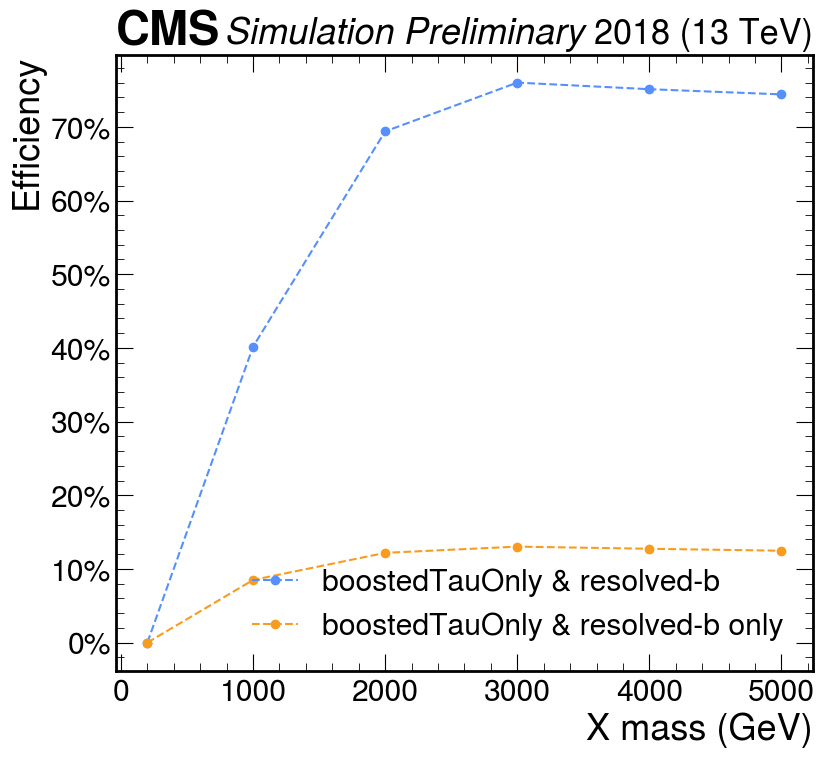

In [9]:
effs = defaultdict(dict)
for mass, ar in ars.items():
    #effs["HPSonly & boosted-bb"][mass] = eff(isHPS(ar) & ~isBoostedTau(ar) & hasBoosted_bb(ar), isReco(ar))
    #effs["HPSonly & boosted-bb only"][mass] = eff(isHPS(ar) & ~isBoostedTau(ar) & ~isRes1Or2b(ar) & hasBoosted_bb(ar), isReco(ar))
    effs["boostedTauOnly & resolved-b"][mass] = eff(~isHPS(ar) & isBoostedTau(ar) & isRes1Or2b(ar), isReco(ar))
    effs["boostedTauOnly & resolved-b only"][mass] = eff(~isHPS(ar) & isBoostedTau(ar) & isRes1Or2b(ar) & ~hasBoosted_bb(ar), isReco(ar))

    # effs["!boostedTau & boosted-bb"][mass] = eff(~isBoostedTau(ar) & hasBoosted_bb(ar), ar)
    # effs["HPSTau & ~boostedTau & boosted-bb & !res"][mass] = eff(isHPS(ar) & hasBoosted_bb(ar), ar)

plt.figure(figsize=(9, 8))
for key, val in effs.items():
    plt.plot(val.keys(), val.values(), "o--", label=key)
# plt.plot(ars.keys(), eff_singlemu_trigger_genmatched.values(), label="HLT_IsoMu24 gen-matched")
plt.xlabel("X mass (GeV)")
plt.ylabel("Efficiency")
#plt.ylim(0, 1.3)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.rcParams['legend.title_fontsize'] = 'small'
plt.legend()
# plt.legend(title=r"$X\to Z_{bb}Z_{\tau\tau}$, $\tau_{\mu}\tau_{h}$ channel (gen-level filter)" "\n" 
#               r"Gen cuts: $\tau_{h}\tau_{h}$ decay" "\n"
#               r"$p_T(\tau_h) > 20 GeV, \eta(\tau_h) < 2.1$, $\Delta R(\tau\tau)<0.6$", loc="upper left", ncols=2)

hep.cms.label("Preliminary", year=2018)
#plt.savefig("studies/cutflow/cutflow_offline_muon_eff.pdf")

(exptext: Custom Text(0.001, 1, 'CMS'),
 expsuffix: Custom Text(0.001, 1.005, 'Simulation Preliminary'),
 supptext: Custom Text(1.012, 1, ''))

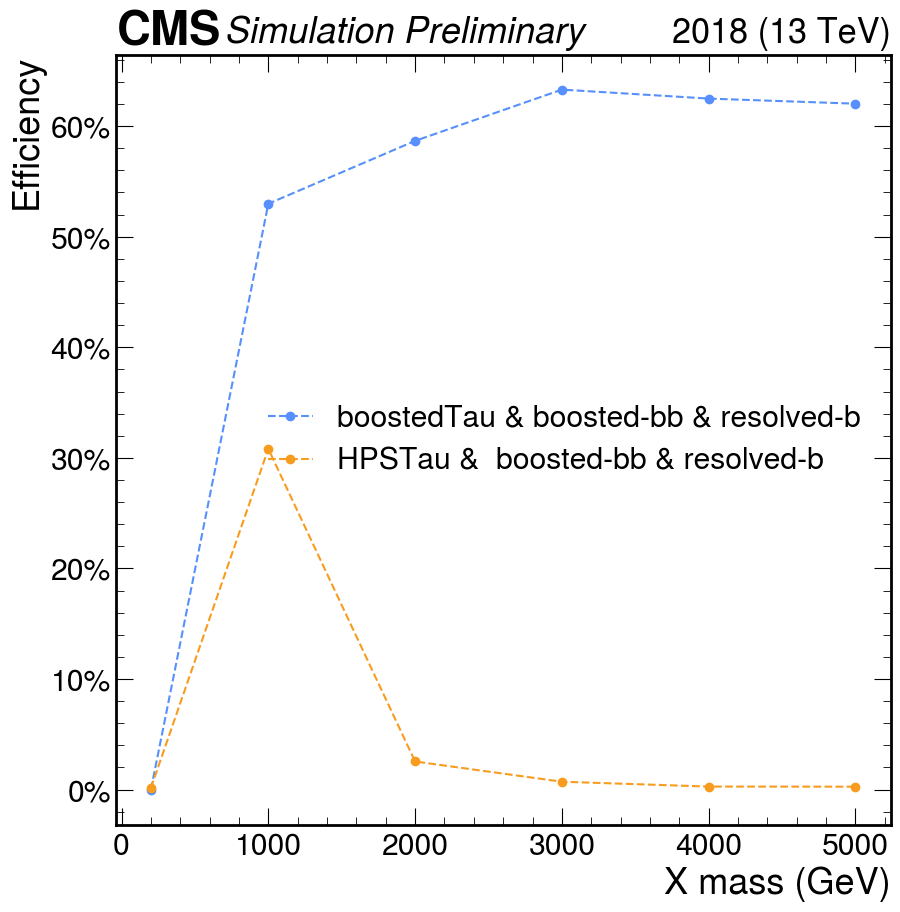

In [121]:
effs = defaultdict(dict)
for mass, ar in ars.items():
    effs["boostedTau & boosted-bb & resolved-b"][mass] = eff(isBoostedTau(ar) & hasBoosted_bb(ar) & isRes1Or2b(ar), isReco(ar))
    effs["HPSTau &  boosted-bb & resolved-b"][mass] = eff(isHPS(ar) & hasBoosted_bb(ar) & isRes1Or2b(ar), isReco(ar))


for key, val in effs.items():
    plt.plot(val.keys(), val.values(), "o--", label=key)
# plt.plot(ars.keys(), eff_singlemu_trigger_genmatched.values(), label="HLT_IsoMu24 gen-matched")
plt.xlabel("X mass (GeV)")
plt.ylabel("Efficiency")
#plt.ylim(0, 1.3)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.rcParams['legend.title_fontsize'] = 'small'
plt.legend()
# plt.legend(title=r"$X\to Z_{bb}Z_{\tau\tau}$, $\tau_{\mu}\tau_{h}$ channel (gen-level filter)" "\n" 
#               r"Gen cuts: $\tau_{h}\tau_{h}$ decay" "\n"
#               r"$p_T(\tau_h) > 20 GeV, \eta(\tau_h) < 2.1$, $\Delta R(\tau\tau)<0.6$", loc="upper left", ncols=2)

hep.cms.label("Preliminary", year=2018)
#plt.savefig("studies/cutflow/cutflow_offline_muon_eff.pdf")

## Bar Plot with categories overlap

In [5]:
vals

array([0.        , 0.05603054, 0.02104981, 0.01640384, 0.01315545,
       0.00944479])

dict_keys([200, 1000, 2000, 3000, 4000, 5000]) [0.         0.06361269 0.18780845 0.20909915 0.21436524 0.20818641] [0. 0. 0. 0. 0. 0.]
dict_keys([200, 1000, 2000, 3000, 4000, 5000]) [0.         0.029924   0.01900002 0.01605945 0.01309979 0.00941713] [0.         0.06361269 0.18780845 0.20909915 0.21436524 0.20818641]
dict_keys([200, 1000, 2000, 3000, 4000, 5000]) [0.         0.03611639 0.14875199 0.17018307 0.17109511 0.16046463] [0.         0.0935367  0.20680847 0.2251586  0.22746502 0.21760354]
dict_keys([200, 1000, 2000, 3000, 4000, 5000]) [0.         0.05504539 0.00736349 0.00242886 0.00098341 0.00107861] [0.         0.12965309 0.35556046 0.39534167 0.39856014 0.37806817]
dict_keys([200, 1000, 2000, 3000, 4000, 5000]) [4.09568532e-03 4.22384069e-02 3.42157960e-03 6.70654341e-04
 2.04104353e-04 9.67987278e-05] [0.         0.18469847 0.36292395 0.39777053 0.39954355 0.37914679]
dict_keys([200, 1000, 2000, 3000, 4000, 5000]) [0.00549601 0.03729505 0.00663818 0.00257386 0.00109474 0.000

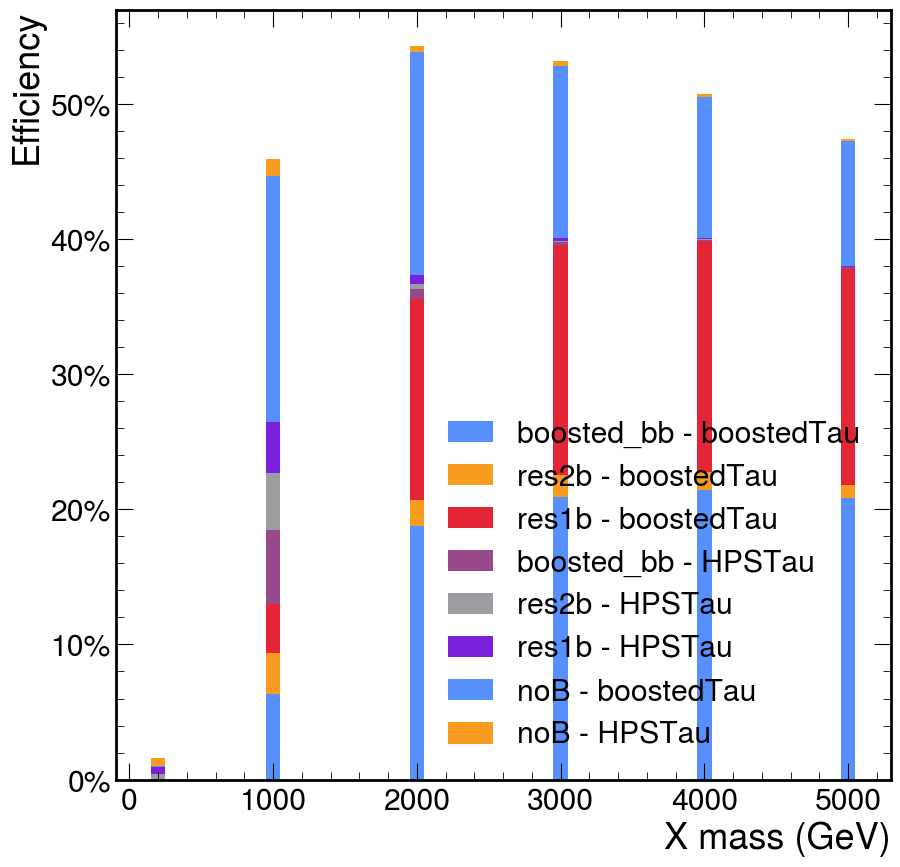

In [17]:
# for mass, ar in ars.items():


fig, ax = plt.subplots()
bottom = np.zeros(len(ars))
for cat_label, cat_lambda in [
    ("boosted_bb - boostedTau", lambda ar : hasBoosted_bb(ar) & isBoostedTau(ar) & ~ isHPS(ar)),
    ("res2b - boostedTau", lambda ar : isRes2b(ar) & isBoostedTau(ar) & ~ isHPS(ar)),
    ("res1b - boostedTau", lambda ar : isRes1b(ar) & isBoostedTau(ar) & ~ isHPS(ar)),
    ("boosted_bb - HPSTau", lambda ar : hasBoosted_bb(ar) & isHPS(ar)),
    ("res2b - HPSTau", lambda ar : isRes2b(ar) & isHPS(ar)),
    ("res1b - HPSTau", lambda ar : isRes1b(ar) & isHPS(ar)),
    ("noB - boostedTau", lambda ar : (~isRes1Or2b(ar) & ~hasBoosted_bb(ar)) & isBoostedTau(ar)& ~ isHPS(ar)),
    ("noB - HPSTau", lambda ar : (~isRes1Or2b(ar) & ~hasBoosted_bb(ar)) & isHPS(ar)),
    ]:
    vals = np.array([eff(cat_lambda(ar), ar) for ar in ars.values()])
    p = ax.bar(ars.keys(), vals, width=100, label=cat_label, bottom=bottom)
    #print(ars.keys(), vals,bottom)
    bottom += vals
ax.legend()
plt.xlabel("X mass (GeV)")
plt.ylabel("Efficiency")
#plt.ylim(0, 1.3)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

## CHecking orthogonality with Tau pt
hi @tcuisset , so the comment is on the selection of the boosted taus.
I think that we shouldn't select taus that are "boosted non-HPS", because that may include a subset of taus which are not well understood.
One idea is to ask the following:
- for the Electron, Muon and Tau datasets, that the events in there have a HPS tau with pT < X GeV (where X is the typical place where HPS starts to be much less efficient than the boosted).
- for the MET dataset, ask that there is a least a boosted tau, and if it is matched to an HPS tau, that the HPS tau has pT > X GeV.
This ensures orthogonality, at the price of losing events that have a HPS pT > X GeV in the Electron/Muon/Tau datasets (which can be substantial).
X can be tuned as to minimize the loss of the sensitivity of the non-resonant analysis under the old categories scheme (i.e. with boosted2b, res2b, res1b).
There is another way which consists in checking event numbers, and "merge" the [Ele/Mu/Tau/MET] datasets on the fly during processing. That is the optimal way, but requires a bit of sw development I suppose.

Losing : 
 - Lepton trig & not MET trigger & HPS pt > X
 - not lepton trig & MET trig & HPS pt < X & boostedTau

In [7]:
pairType = 0
# ar = ars[3000]
mass = 3000
# ar = uproot.concatenate([f"/grid_mnt/data__data.polcms/cms/cuisset/cmt/PreprocessRDF/bul_2018_ZZ_v12/GluGluToXToZZTo2B2Tau_M{mass}/cat_base/prod_241023g/data_{i}.root:Events" for i in range(1)], how="zip", 
#     filter_name=["FatJet_particleNet*", "FatJet_pt", "FatJet_eta", "FatJet_phi", "fatjet_JetIdx", "genPairType", "is*", "pairType*", "bjet1_JetIdx", "bjet2_JetIdx", "Jet_btagDeepFlavB", "Jet_pt", "Jet_eta",
#                  "dau*", "HLT_*", "MET_pt", "Tau_eta", "Tau_phi", "Tau_decayMode", "Tau_pt", "Tau_dz", "Tau_idDeepTau2017*"])
# ar = ar[ar.genPairType == pairType]
ar = ars[mass][ ars[mass].genPairType == pairType]

In [8]:
def delta_phi(a, b):
    """Compute difference in angle given two angles a and b

    Returns a value within [-pi, pi)
    """
    return (a - b + np.pi) % (2 * np.pi) - np.pi

def delta_r(eta1, phi1, eta2, phi2):
    r"""Distance in (eta,phi) plane given two pairs of (eta,phi)

    :math:`\sqrt{\Delta\eta^2 + \Delta\phi^2}`
    """
    deta = eta1 - eta2
    dphi = delta_phi(phi1, phi2)
    return np.hypot(deta, dphi)

In [212]:
ar_f = ar[ar.pairType_boostedTaus == pairType]

In [22]:
def match_HPStau(ar, Y):
    """ checks if dau2 is matched to HPS tau with pt<Y"""
    good_taus = ar.Tau[((ar.Tau.decayMode == 0) | (ar.Tau.decayMode == 1) | (ar.Tau.decayMode == 10) | (ar.Tau.decayMode == 11)) 
                       & (ar.Tau.idDeepTau2017v2p1VSe>=2) & (ar.Tau.idDeepTau2017v2p1VSmu>=4) & (ar.Tau.idDeepTau2017v2p1VSjet>=5)] # VsMu is Tight=4 for etau/mutau or VLoose=1 for tautau
    
    return ak.fill_none(ak.firsts(good_taus[delta_r(ar.dau2_eta, ar.dau2_phi, good_taus.eta, good_taus.phi) < 0.3].pt) < Y, False)

In [23]:
def make_one_two(ar, Y, pairType):
    """ make the two failed categories one & two"""
    met_trigger = (ar.MET_pt > 180) & (ar.HLT_PFMETNoMu120_PFMHTNoMu120_IDTight | ar.HLT_MonoCentralPFJet80_PFMETNoMu120_PFMHTNoMu120_IDTight | ar.HLT_PFMET120_PFMHT120_IDTight)
    if pairType == 0:
        lep_trigger = ar.HLT_IsoMu24 | ar.HLT_IsoMu20_eta2p1_LooseChargedIsoPFTauHPS27_eta2p1_CrossL1
    elif pairType == 1:
        lep_trigger = ar.HLT_Ele32_WPTight_Gsf | ar.HLT_Ele24_eta2p1_WPTight_Gsf_LooseChargedIsoPFTauHPS30_eta2p1_CrossL1
    elif pairType == 2:
        lep_trigger = ar.HLT_DoubleMediumChargedIsoPFTauHPS35_Trk1_eta2p1_Reg
    return (
        (ar.pairType_HPSTaus == pairType ) & ~met_trigger & ((ar.dau2_pt > Y)), 
        (~lep_trigger) & (met_trigger) & (ar.pairType_boostedTaus == pairType ) & match_HPStau(ar, Y)
    )
def totalLostPercent(ar, Y, pairType):
    one, two = make_one_two(ar, Y, pairType)
    return ak.count_nonzero(one) / len(ar) * 100 + ak.count_nonzero(two) / len(ar) * 100

In [24]:
Y=100
met_trigger = (ar.MET_pt > 180) & (ar.HLT_PFMETNoMu120_PFMHTNoMu120_IDTight | ar.HLT_MonoCentralPFJet80_PFMETNoMu120_PFMHTNoMu120_IDTight | ar.HLT_PFMET120_PFMHT120_IDTight)
lep_trigger = ar.HLT_IsoMu24 | ar.HLT_IsoMu20_eta2p1_LooseChargedIsoPFTauHPS27_eta2p1_CrossL1
evts = (~lep_trigger) & (met_trigger) & (ar.pairType_boostedTaus == pairType ) & ak.fill_none(ak.firsts(ar.Tau[delta_r(ar.dau2_eta, ar.dau2_phi, ar.Tau.eta, ar.Tau.phi) < 0.3].pt) < Y, False)

In [196]:
ak.count_nonzero(evts)/len(ar)

0.010110362195392934

/opt/exp_soft/llr/python/3.11.8/el7/lib/python3.11/site-packages/awkward/_nplikes/array_module.py:245: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))
/opt/exp_soft/llr/python/3.11.8/el7/lib/python3.11/site-packages/awkward/_nplikes/array_module.py:245: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


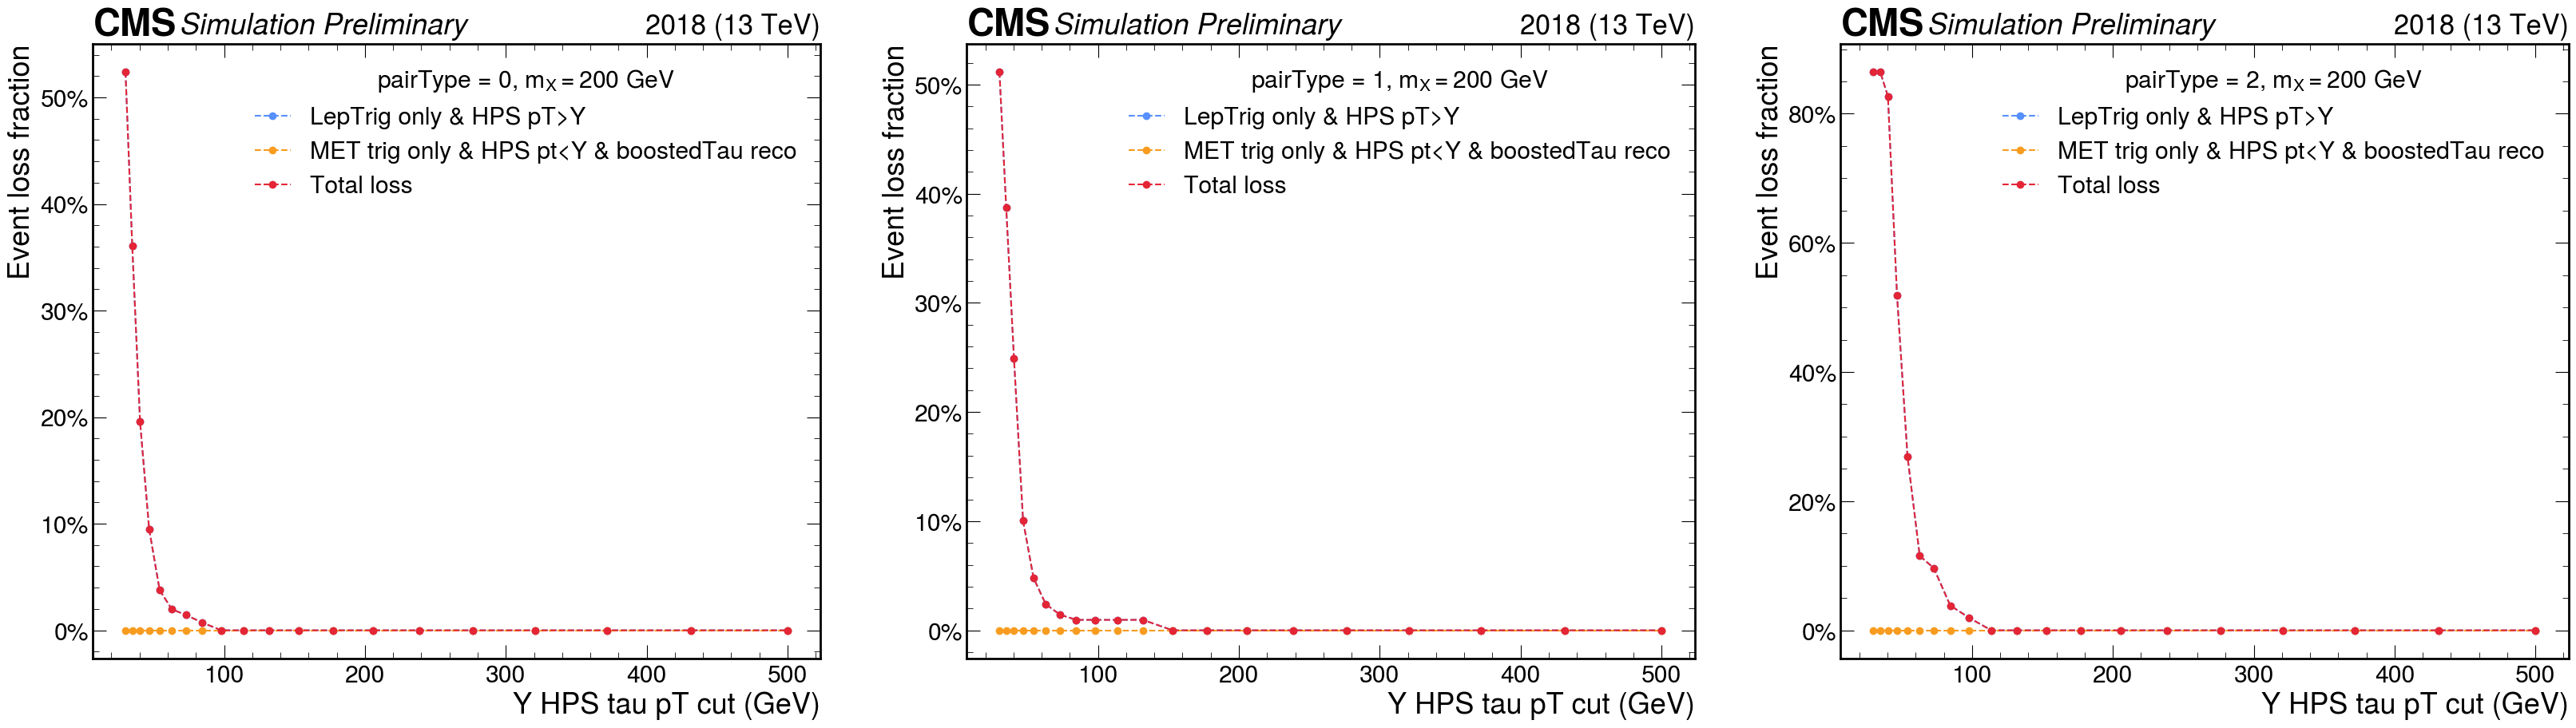

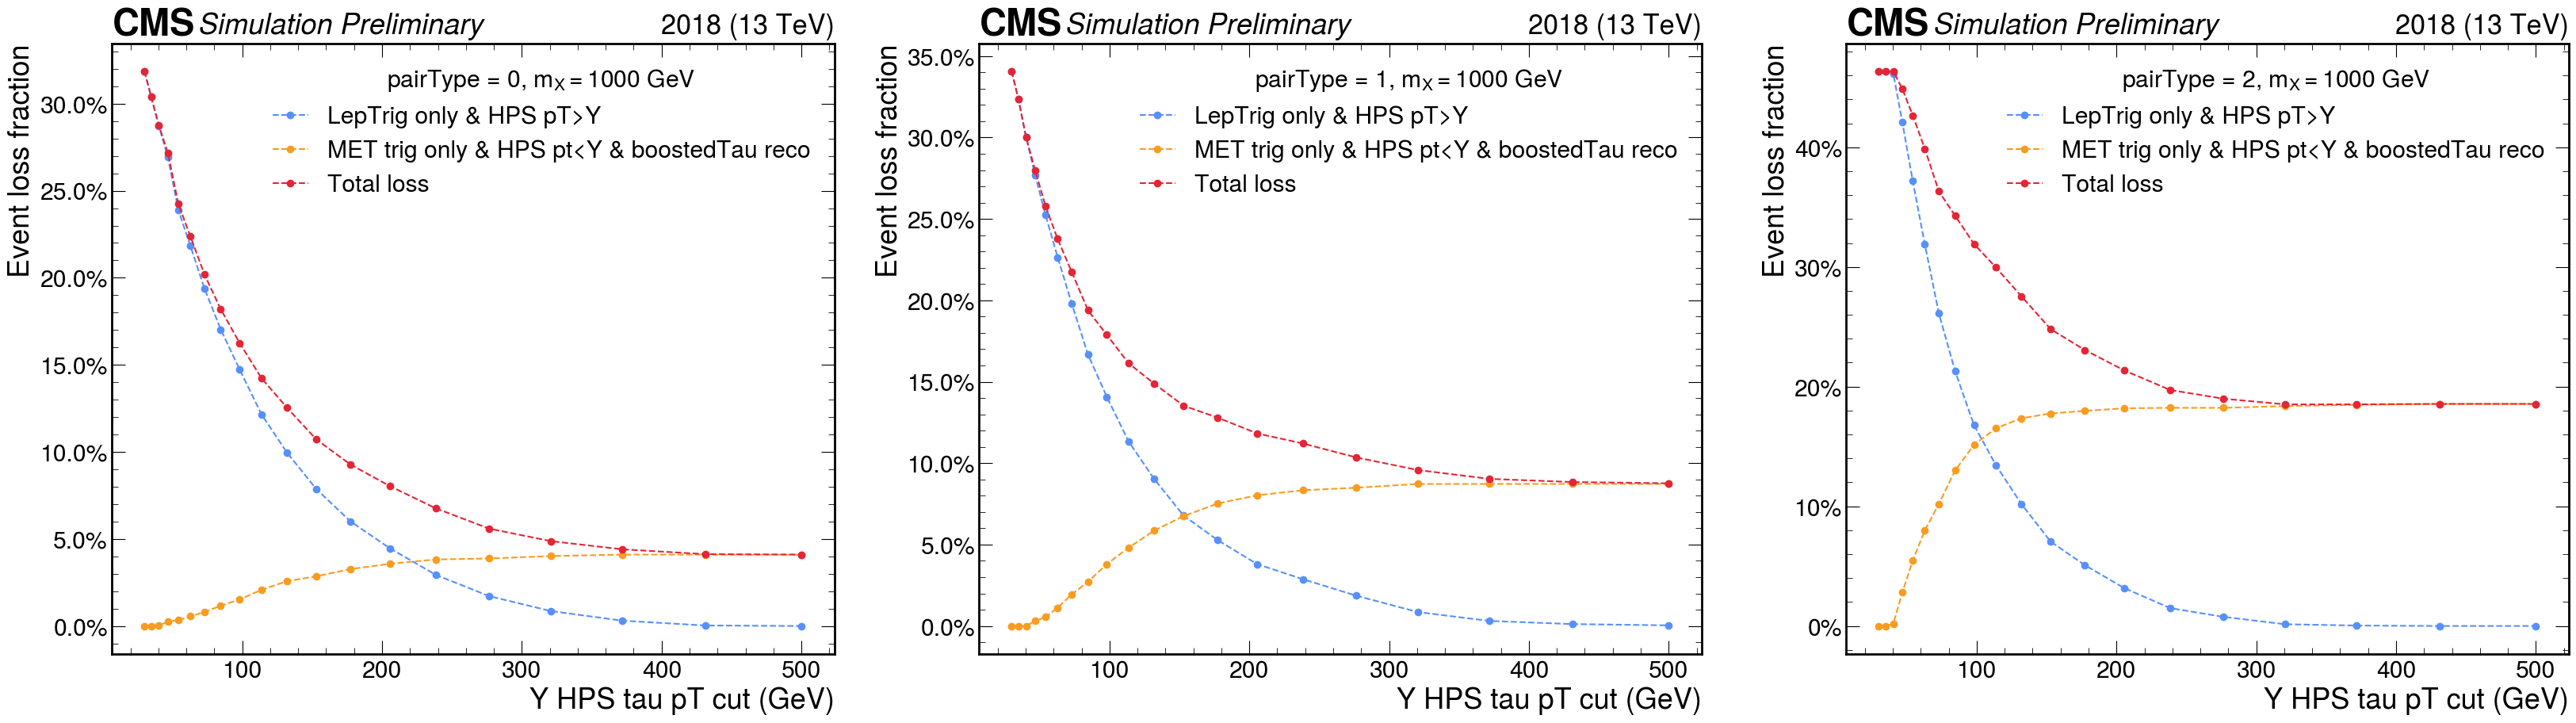

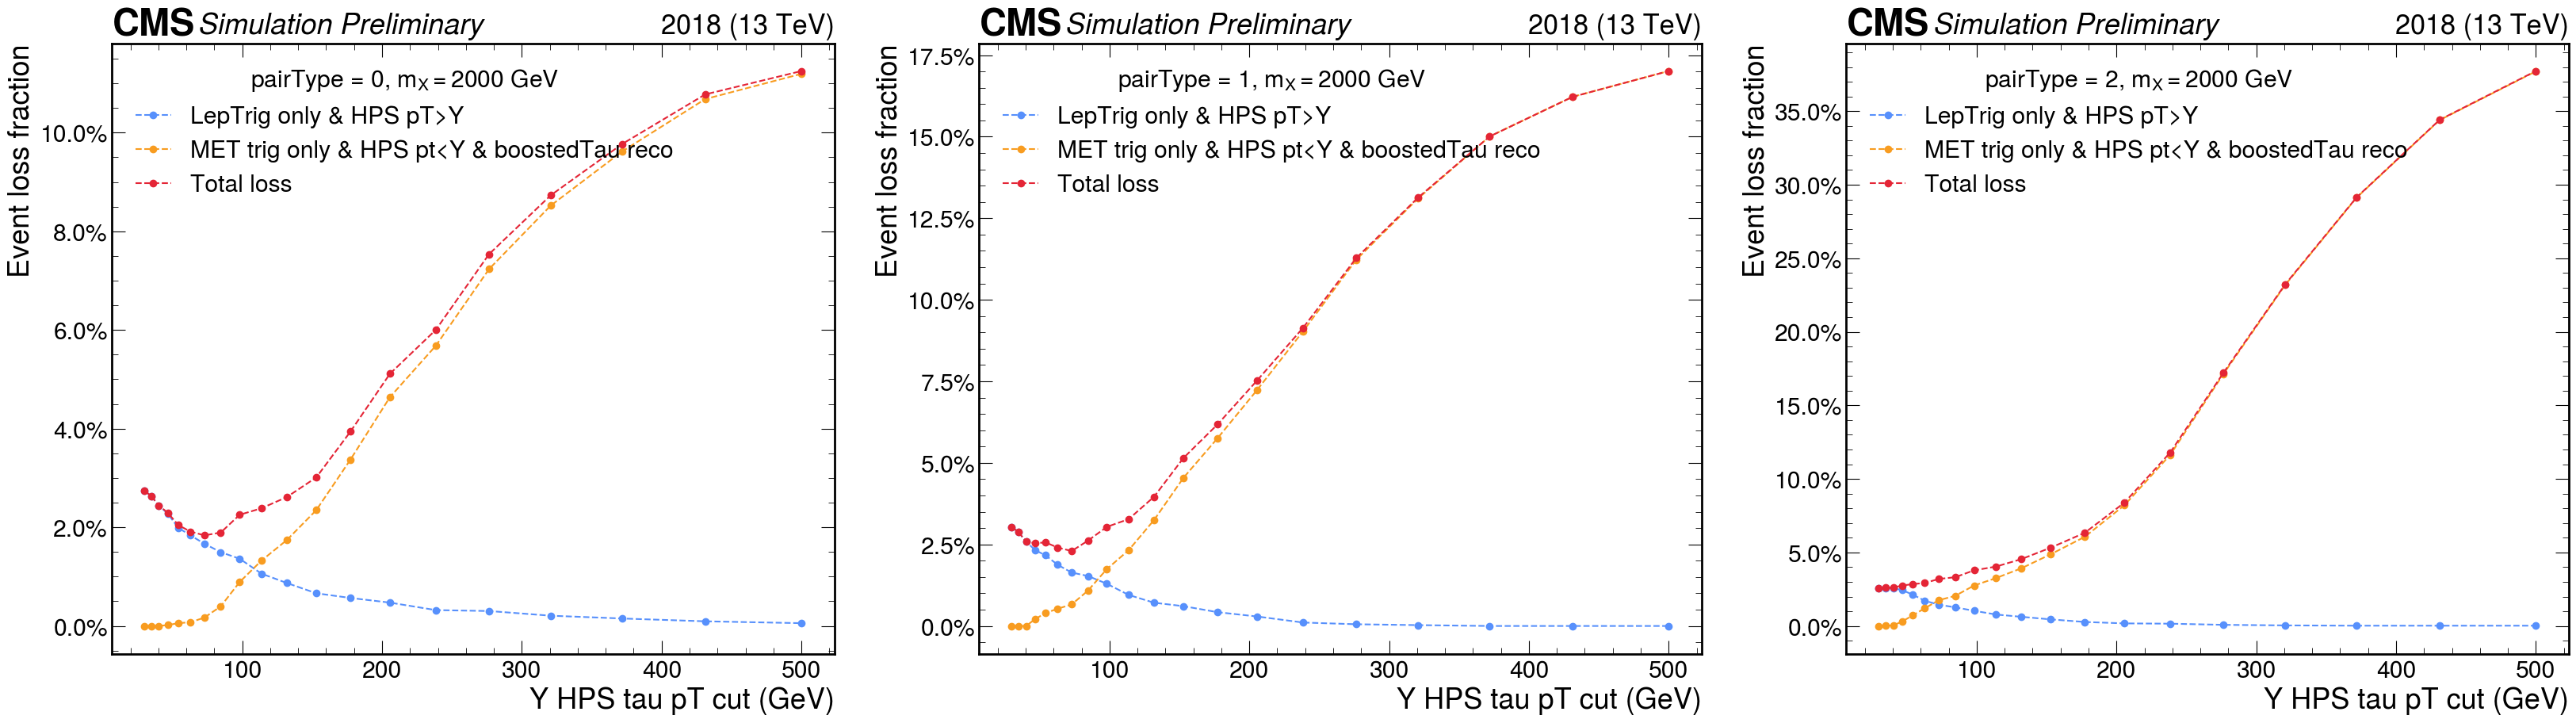

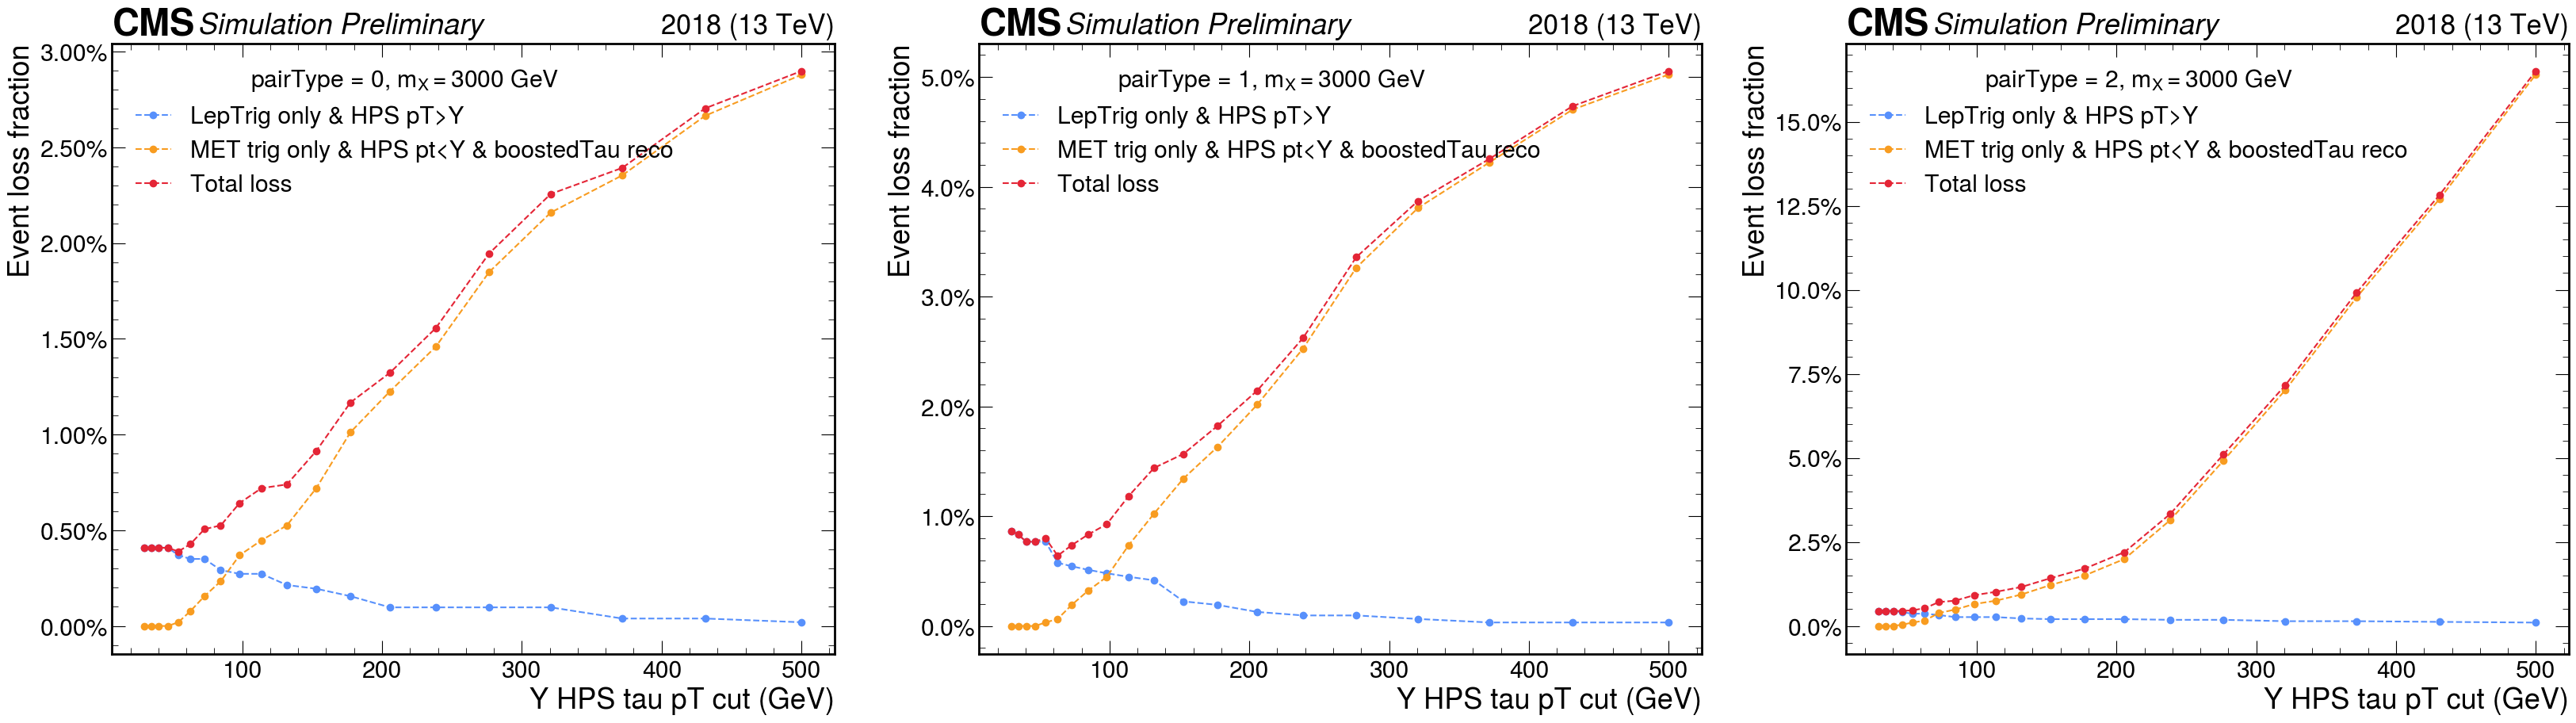

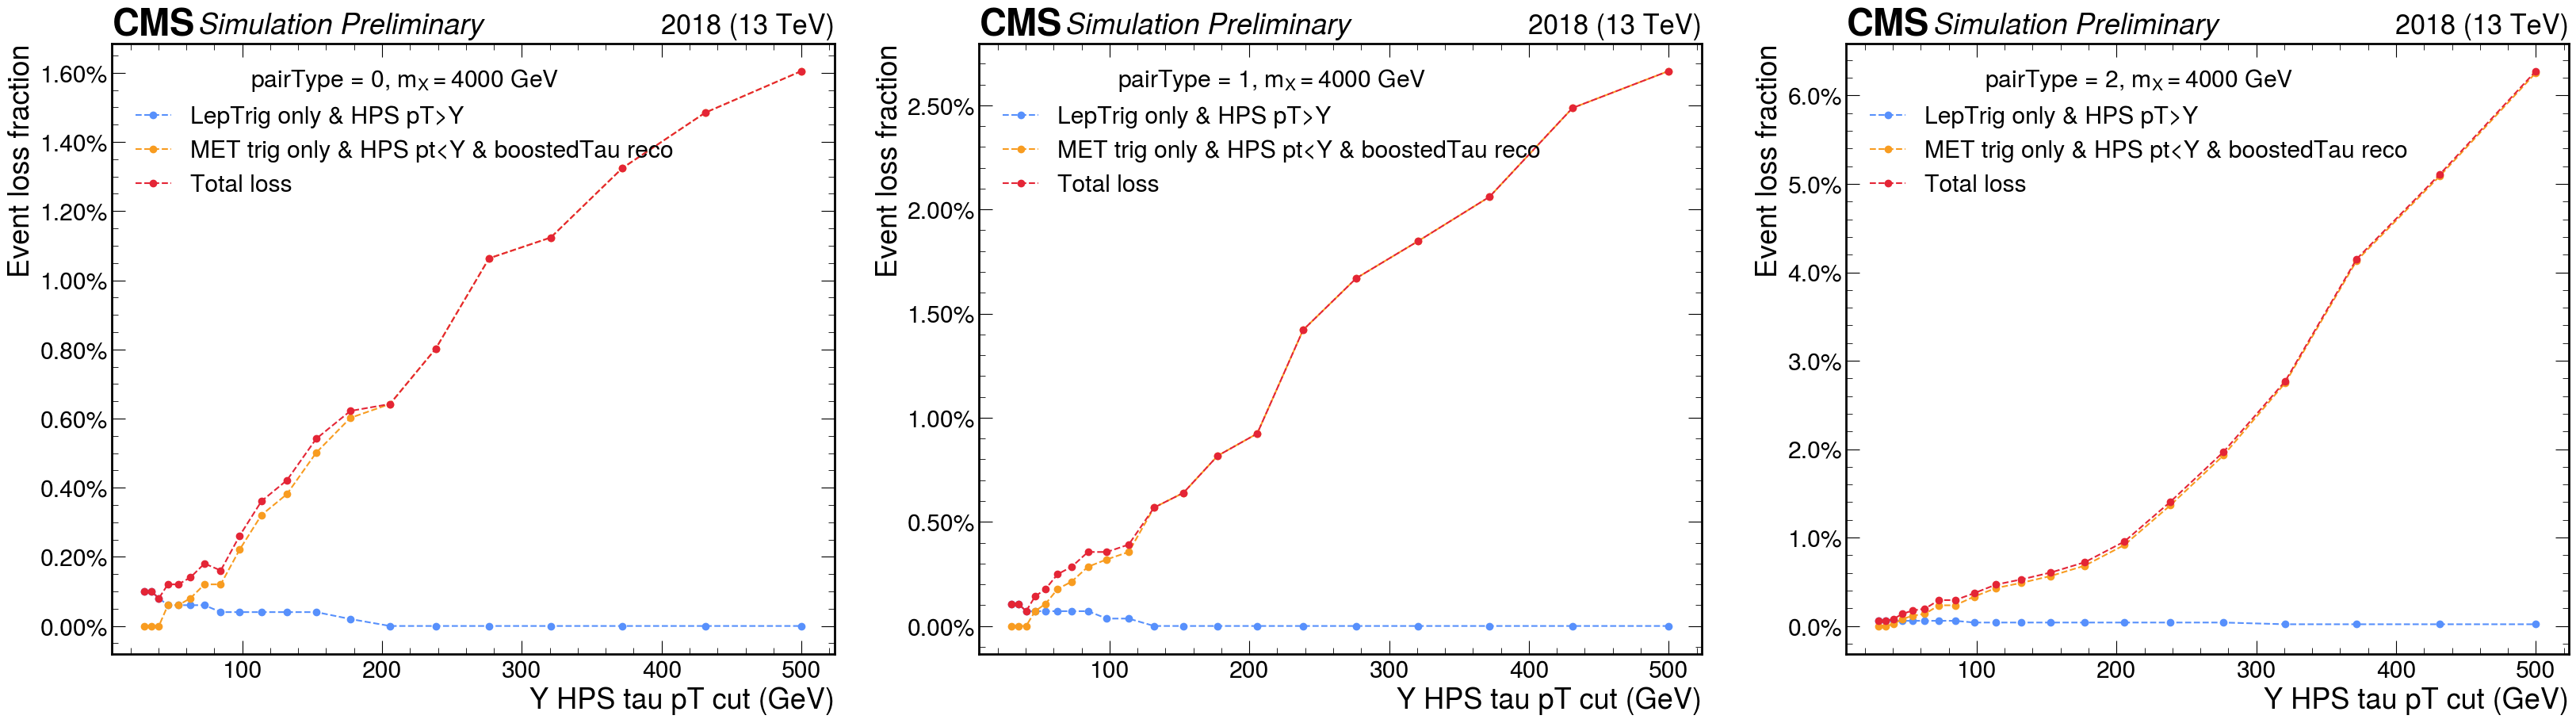

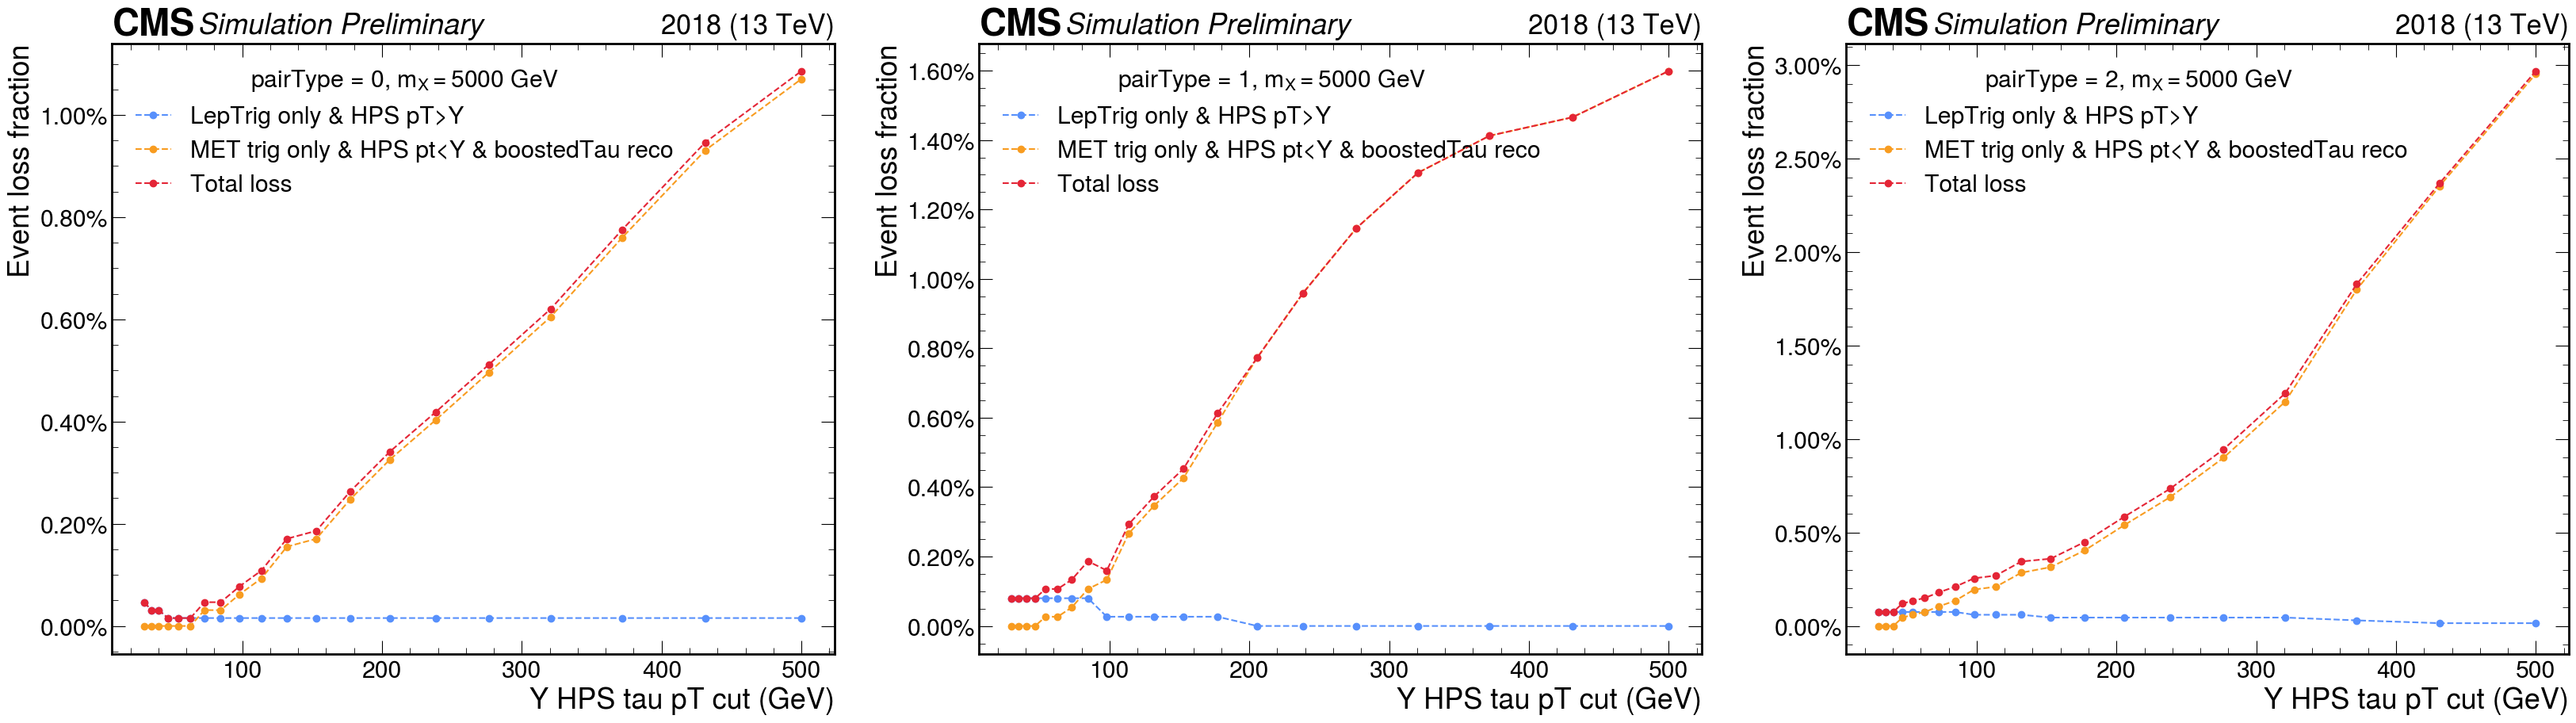

In [25]:
for mass, ar_raw in ars.items():
    fig, axs = plt.subplots(1, 3, figsize=(40, 10))
    for pairType, ax in enumerate(axs):
        plt.sca(ax)
        ar = ar_raw[ar_raw.genPairType == pairType]
        effs = defaultdict(dict)
        import math
        for Y in np.logspace(math.log10(30), math.log10(500), 20):
            one, two = make_one_two(ar, Y, pairType)
            effs["LepTrig only & HPS pT>Y"][Y] = eff(one & isReco(ar), isReco(ar))
            effs["MET trig only & HPS pt<Y & boostedTau reco"][Y] = eff(two & isReco(ar), isReco(ar))
            effs["Total loss"][Y] = eff((one | two) & isReco(ar), isReco(ar))


        for key, val in effs.items():
            plt.plot(val.keys(), val.values(), "o--", label=key)
        # plt.plot(ars.keys(), eff_singlemu_trigger_genmatched.values(), label="HLT_IsoMu24 gen-matched")
        plt.xlabel("Y HPS tau pT cut (GeV)")
        plt.ylabel("Event loss fraction")
        #plt.ylim(0, 1.3)
        #plt.xscale("log")
        plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
        plt.rcParams['legend.title_fontsize'] = 'small'
        plt.legend(title=f"pairType = {pairType}, $m_X = {mass}$ GeV")
        # plt.legend(title=r"$X\to Z_{bb}Z_{\tau\tau}$, $\tau_{\mu}\tau_{h}$ channel (gen-level filter)" "\n" 
        #               r"Gen cuts: $\tau_{h}\tau_{h}$ decay" "\n"
        #               r"$p_T(\tau_h) > 20 GeV, \eta(\tau_h) < 2.1$, $\Delta R(\tau\tau)<0.6$", loc="upper left", ncols=2)

        hep.cms.label("Preliminary", year=2018)
        #plt.savefig("studies/cutflow/cutflow_offline_muon_eff.pdf")

18.9819422721456

In [28]:
ar = ars[1000][ ars[1000].genPairType == 0]
one, two = make_one_two(ar, 150, pairType=0)
eff(one & isReco(ar), isReco(ar)), eff(two & isReco(ar), isReco(ar))

/opt/exp_soft/llr/python/3.11.8/el7/lib/python3.11/site-packages/awkward/_nplikes/array_module.py:245: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


(0.07975630019385212, 0.027970091387427305)

In [30]:
ar[two]

<Array [{MET_pt: 208, ...}, {...}, ..., {...}] type='108 * {MET_pt: float32...'>